In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%cp -r /content/drive/My\ Drive/TDT4265 /content/
%cd /content/TDT4265

/content/TDT4265


In [4]:
import torch
import torch.nn as nn
from dataloaders import load_cifar10
from trainer import Trainer, compute_loss_and_accuracy
from task2 import create_plots

print(torch.__version__)
print(torch.cuda.get_device_name(0))

1.10.0+cu111
Tesla P100-PCIE-16GB


## Rewriting of ```trainer``` functions

Optimizer is set as an argument to the ```Trainer``` class to allow changing of optimizer for later use.

```validation_step``` method is updated to keep track of train loss as well as  test accuracy and loss. They are also printed when validating for us to see.

In [267]:
import torch
import typing
import time
import collections
import utils
import pathlib


def compute_loss_and_accuracy(
        dataloader: torch.utils.data.DataLoader,
        model: torch.nn.Module,
        loss_criterion: torch.nn.modules.loss._Loss):
    """
    Computes the average loss and the accuracy over the whole dataset
    in dataloader.
    Args:
        dataloder: Validation/Test dataloader
        model: torch.nn.Module
        loss_criterion: The loss criterion, e.g: torch.nn.CrossEntropyLoss()
    Returns:
        [average_loss, accuracy]: both scalar.
    """
    average_loss = 0
    accuracy = 0
    losses = 0
    corrects = 0    
    total_count = 0
    # TODO: Implement this function (Task  2a)
    with torch.no_grad():
        for (X_batch, Y_batch) in dataloader:
            # Transfer images/labels to GPU VRAM, if possible
            X_batch = utils.to_cuda(X_batch)
            Y_batch = utils.to_cuda(Y_batch)
            # Forward pass the images through our model
            output_probs = model(X_batch)
            Y_hat = output_probs.argmax(axis=1)

            losses += loss_criterion(output_probs, Y_batch).item()

            corrects += torch.sum(Y_hat == Y_batch).item()
            total_count += len(Y_batch)

            # Compute Loss and Accuracy
        average_loss = losses / len(dataloader)
        accuracy = corrects / total_count


    return average_loss, accuracy


class Trainer:

    def __init__(self,
                 batch_size: int,
                 learning_rate: float,
                 early_stop_count: int,
                 epochs: int,
                 model: torch.nn.Module,
                 dataloaders: typing.List[torch.utils.data.DataLoader],
                 optimizer: torch.optim.Optimizer):
        """
            Initialize our trainer class.
        """
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.early_stop_count = early_stop_count
        self.epochs = epochs

        # Since we are doing multi-class classification, we use CrossEntropyLoss
        self.loss_criterion = torch.nn.CrossEntropyLoss()
        # Initialize the model
        self.model = model
        # Transfer model to GPU VRAM, if possible.
        self.model = utils.to_cuda(self.model)
        print(self.model)

        # Define our optimizer. SGD = Stochastich Gradient Descent
        self.optimizer = optimizer(self.model.parameters(),
                                   self.learning_rate)
        # self.optimizer = torch.optim.SGD(self.model.parameters(),
        #                                  self.learning_rate)

        # Load our dataset
        self.dataloader_train, self.dataloader_val, self.dataloader_test = dataloaders

        # Validate our model everytime we pass through 50% of the dataset
        self.num_steps_per_val = len(self.dataloader_train) // 2
        self.global_step = 0
        self.start_time = time.time()

        # Tracking variables
        self.train_history = dict(
            loss=collections.OrderedDict(),
            accuracy=collections.OrderedDict()

        )
        self.validation_history = dict(
            loss=collections.OrderedDict(),
            accuracy=collections.OrderedDict()
        )
        self.test_history = dict(
            loss=collections.OrderedDict(),
            accuracy=collections.OrderedDict()
        )
        self.checkpoint_dir = pathlib.Path("checkpoints")

    def validation_step(self):
        """
            Computes the loss/accuracy for all three datasets.
            Train, validation and test.
        """
        self.model.eval()
        validation_loss, validation_acc = compute_loss_and_accuracy(
            self.dataloader_val, self.model, self.loss_criterion
        )
        self.validation_history["loss"][self.global_step] = validation_loss
        self.validation_history["accuracy"][self.global_step] = validation_acc

        test_loss, test_acc = compute_loss_and_accuracy(
            self.dataloader_test, self.model, self.loss_criterion
        )
        self.test_history["loss"][self.global_step] = test_loss
        self.test_history["accuracy"][self.global_step] = test_acc

        train_loss, train_acc = compute_loss_and_accuracy(
            self.dataloader_train, self.model, self.loss_criterion
        )
        self.train_history["loss"][self.global_step] = train_loss
        self.train_history["accuracy"][self.global_step] = train_acc

        used_time = time.time() - self.start_time


        print(
            f"Epoch: {self.epoch:>1}",
            f"Batches per seconds: {self.global_step / used_time:.2f}",
            f"Global step: {self.global_step:>6}",
            "\n"
            f"Train Loss: {train_loss:.2f}",
            f"Train Accuracy: {train_acc:.3f}",
            f"Validation Loss: {validation_loss:.2f}",
            f"Validation Accuracy: {validation_acc:.3f}",
            f"Test Loss: {test_loss:.3f}",
            f"Test Accuracy: {test_acc:.3f}",
            sep=", ")
        self.model.train()


    def should_early_stop(self):
        """
            Checks if validation loss doesn't improve over early_stop_count epochs.
        """
        # Check if we have more than early_stop_count elements in our validation_loss list.
        val_loss = self.validation_history["loss"]
        if len(val_loss) < self.early_stop_count:
            return False
        # We only care about the last [early_stop_count] losses.
        relevant_loss = list(val_loss.values())[-self.early_stop_count:]
        first_loss = relevant_loss[0]
        if first_loss == min(relevant_loss):
            print("Early stop criteria met")
            return True
        return False

    def train_step(self, X_batch, Y_batch):
        """
        Perform forward, backward and gradient descent step here.
        The function is called once for every batch (see trainer.py) to perform the train step.
        The function returns the mean loss value which is then automatically logged in our variable self.train_history.

        Args:
            X: one batch of images
            Y: one batch of labels
        Returns:
            loss value (float) on batch
        """
        # X_batch is the CIFAR10 images. Shape: [batch_size, 3, 32, 32]
        # Y_batch is the CIFAR10 image label. Shape: [batch_size]
        # Transfer images / labels to GPU VRAM, if possible
        X_batch = utils.to_cuda(X_batch)
        Y_batch = utils.to_cuda(Y_batch)

        # Perform the forward pass
        predictions = self.model(X_batch)
        # Compute the cross entropy loss for the batch
        loss = self.loss_criterion(predictions, Y_batch)
        # Backpropagation
        loss.backward()
        # Gradient descent step
        self.optimizer.step()
        # Reset all computed gradients to 0
        self.optimizer.zero_grad()

        return loss.detach().cpu().item()

    def train(self):
        """
        Trains the model for [self.epochs] epochs.
        """
        def should_validate_model():
            return self.global_step % self.num_steps_per_val == 0

        for epoch in range(self.epochs):
            self.epoch = epoch
            # Perform a full pass through all the training samples
            for X_batch, Y_batch in self.dataloader_train:
                loss = self.train_step(X_batch, Y_batch)
                self.train_history["loss"][self.global_step] = loss
                

                self.global_step += 1
                # Compute loss/accuracy for validation set
                if should_validate_model():

                    self.validation_step()
                    self.save_model()
                    if self.should_early_stop():
                        print("Early stopping.")
                        return

    def save_model(self):
        def is_best_model():
            """
                Returns True if current model has the lowest validation loss
            """
            val_loss = self.validation_history["loss"]
            validation_losses = list(val_loss.values())
            return validation_losses[-1] == min(validation_losses)

        state_dict = self.model.state_dict()
        filepath = self.checkpoint_dir.joinpath(f"{self.global_step}.ckpt")

        utils.save_checkpoint(state_dict, filepath, is_best_model())

    def load_best_model(self):
        state_dict = utils.load_best_checkpoint(self.checkpoint_dir)
        if state_dict is None:
            print(
                f"Could not load best checkpoint. Did not find under: {self.checkpoint_dir}")
            return
        self.model.load_state_dict(state_dict)


# Task 2

In [268]:
class Task2Model(nn.Module):

    def __init__(self,
                 image_channels,
                 num_classes):
        """
            Is called when model is initialized.
            Args:
                image_channels. Number of color channels in image (3)
                num_classes: Number of classes we want to predict (10)
        """
        super().__init__()
        self.num_classes = num_classes

        self.conv_stack = nn.Sequential(
            nn.Conv2d(in_channels=image_channels, out_channels=32, 
                      kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(in_channels=32, out_channels=64, 
                      kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(in_channels=64, out_channels=128, 
                      kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )

        self.fc_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(2048, 64),
            nn.ReLU(),
            nn.Linear(64, 10)
        )

    def forward(self, x):
        """
        Performs a forward pass through the model
        Args:
            x: Input image, shape: [batch_size, 3, 32, 32]
        """
        batch_size = x.shape[0]
        out = self.conv_stack(x)
        out = self.fc_stack(out)
        expected_shape = (batch_size, self.num_classes)
        assert out.shape == (batch_size, self.num_classes),\
            f"Expected output of forward pass to be: {expected_shape}, but got: {out.shape}"
        return out

In [269]:
epochs = 100
batch_size = 64
learning_rate = 1e-2 # Should be 5e-5 for LeNet
early_stop_count = 4
dataloaders = load_cifar10(batch_size)
optimizer = torch.optim.SGD
task2_model = Task2Model(image_channels=3, num_classes=10)
task2_trainer = Trainer(
    batch_size,
    learning_rate,
    early_stop_count,
    epochs,
    task2_model,
    dataloaders,
    optimizer
)
task2_trainer.train()

Files already downloaded and verified
Files already downloaded and verified
Task2Model(
  (conv_stack): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2048, out_features=64, bias=True)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=10, bias=True)
  )
)
Epoch: 0, Batches per seconds: 21.27, Global step:    351, 
Train Loss: 2.07, Train Accuracy: 0.244, Validation Loss: 2.07, Validation Accuracy

In [304]:
def print_train_val_test_acc(trainer, idx=-1):
    print("Train: ", list(trainer.train_history["accuracy"].items())[idx])
    print("Validation: ", list(trainer.validation_history["accuracy"].items())[idx])
    print("Test: ", list(trainer.test_history["accuracy"].items())[idx])

In [303]:
print_train_val_test_acc(task2_trainer)

Train:  (12285, 0.829325213371266)
Validation:  (12285, 0.7184)
Test:  (12285, 0.7127)


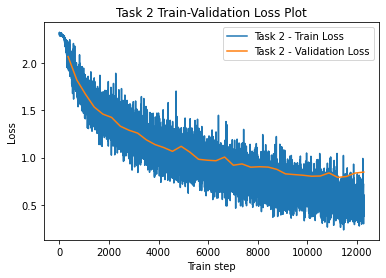

In [271]:
utils.plot_loss(task2_trainer.train_history["loss"], "Task 2 - Train Loss")
utils.plot_loss(task2_trainer.validation_history["loss"], "Task 2 - Validation Loss")
plt.legend()
plt.ylabel("Loss")
plt.xlabel("Train step")
plt.title("Task 2 Train-Validation Loss Plot")

plt.savefig("task2_loss_plot.png")
plt.show()

# Task 3

## Task 3 Testing Model

Test stacking of Convolution layers instead of having MaxPool2D between each of them seen in Table 1.

In [308]:
class Task3_Model_test(nn.Module):

    def __init__(self,
                 image_channels,
                 num_classes):
        """
            Is called when model is initialized.
            Args:
                image_channels. Number of color channels in image (3)
                num_classes: Number of classes we want to predict (10)
        """
        super().__init__()
        # num_filters = 32  # Set number of filters in first conv layer
        self.num_classes = num_classes

        self.conv_stack = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.BatchNorm2d(128),
        )

        self.fc_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32768, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        """
        Performs a forward pass through the model
        Args:
            x: Input image, shape: [batch_size, 3, 32, 32]
        """
        batch_size = x.shape[0]
        out = self.conv_stack(x)
        out = self.fc_stack(out)
        expected_shape = (batch_size, self.num_classes)
        assert out.shape == (batch_size, self.num_classes),\
            f"Expected output of forward pass to be: {expected_shape}, but got: {out.shape}"
        return out

In [309]:
epochs = 10
batch_size = 64
learning_rate = 1e-2 # Should be 5e-5 for LeNet
early_stop_count = 10
dataloaders = load_cifar10(batch_size)
optimizer = torch.optim.SGD
task3_model_test = Task3_Model_test(image_channels=3, num_classes=10)
task3_trainer_test = Trainer(
    batch_size,
    learning_rate,
    early_stop_count,
    epochs,
    task3_model_test,
    dataloaders,
    optimizer
)
task3_trainer_test.train()

Files already downloaded and verified
Files already downloaded and verified
Task3_Model_test(
  (conv_stack): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=32768, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): ReLU()
    (5): Linear(in_features=128, out_features=10, bias=True)
  )
)
Epoch: 0, Batches per seconds: 18.46, Global step:    351, 
Train Loss: 1.24, Train Accuracy: 0.554, Validation Loss: 1.29, Validation

We see a slight improvement ontop of the base model in task 2.

## Task 3 Model 1
Implement the improvement in the test + create another of such block.

In [272]:
class Task3_Model_1(nn.Module):

    def __init__(self,
                 image_channels,
                 num_classes):
        """
            Is called when model is initialized.
            Args:
                image_channels. Number of color channels in image (3)
                num_classes: Number of classes we want to predict (10)
        """
        super().__init__()
        # num_filters = 32  # Set number of filters in first conv layer
        self.num_classes = num_classes

        self.conv_stack = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.BatchNorm2d(128),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.BatchNorm2d(1024)
        )

        self.fc_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(65536, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        """
        Performs a forward pass through the model
        Args:
            x: Input image, shape: [batch_size, 3, 32, 32]
        """
        batch_size = x.shape[0]
        out = self.conv_stack(x)
        out = self.fc_stack(out)
        expected_shape = (batch_size, self.num_classes)
        assert out.shape == (batch_size, self.num_classes),\
            f"Expected output of forward pass to be: {expected_shape}, but got: {out.shape}"
        return out

In [273]:
epochs = 10
batch_size = 64
learning_rate = 1e-2 # Should be 5e-5 for LeNet
early_stop_count = 10
dataloaders = load_cifar10(batch_size)
optimizer = torch.optim.SGD
task3_model_1 = Task3_Model_1(image_channels=3, num_classes=10)
task3_trainer_1 = Trainer(
    batch_size,
    learning_rate,
    early_stop_count,
    epochs,
    task3_model_1,
    dataloaders,
    optimizer
)
task3_trainer_1.train()

Files already downloaded and verified
Files already downloaded and verified
Task3_Model_1(
  (conv_stack): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True,

Expected >= 0.8 Test accuracy

In [302]:
print_train_val_test_acc(task3_trainer_1)
print()
list(task3_trainer_1.train_history["loss"].items())[-1]

Train:  (6318, 1.0)
Validation:  (6318, 0.8096)
Test:  (6318, 0.8046)



(6318, 0.0006940151073116741)

## Task 3 Model 2
We alternate between MaxPool2D to allow the model to have more sequential convolution layers and build more complex features before taking the max activation. We also use gradually increasing kernel sizes to observe the impact of it.

In [274]:
class Task3_Model_2(nn.Module):

    def __init__(self,
                 image_channels,
                 num_classes):
        """
            Is called when model is initialized.
            Args:
                image_channels. Number of color channels in image (3)
                num_classes: Number of classes we want to predict (10)
        """
        super().__init__()
        # num_filters = 32  # Set number of filters in first conv layer
        self.num_classes = num_classes

        self.conv_stack = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=7, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )

        self.fc_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(4608, 64),
            nn.ReLU(),
            nn.Linear(64, 10)
        )

    def forward(self, x):
        """
        Performs a forward pass through the model
        Args:
            x: Input image, shape: [batch_size, 3, 32, 32]
        """
        batch_size = x.shape[0]
        out = self.conv_stack(x)
        out = self.fc_stack(out)
        expected_shape = (batch_size, self.num_classes)
        assert out.shape == (batch_size, self.num_classes),\
            f"Expected output of forward pass to be: {expected_shape}, but got: {out.shape}"
        return out

In [275]:
epochs = 10
batch_size = 64
learning_rate = 1e-2 # Should be 5e-5 for LeNet
early_stop_count = 10
dataloaders = load_cifar10(batch_size)
optimizer = torch.optim.SGD
task3_model_2 = Task3_Model_2(image_channels=3, num_classes=10)
task3_trainer_2 = Trainer(
    batch_size,
    learning_rate,
    early_stop_count,
    epochs,
    task3_model_2,
    dataloaders,
    optimizer
)
task3_trainer_2.train()

Files already downloaded and verified
Files already downloaded and verified
Task3_Model_2(
  (conv_stack): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (4): ReLU()
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (10): ReLU()
    (11): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Conv2d(256, 512, kernel_size=(7, 7), stride=(1, 1), padding=(2, 2))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, cei

In [301]:
print_train_val_test_acc(task3_trainer_2)
print()
list(task3_trainer_2.train_history["loss"].items())[-1]

Train:  (7020, 0.999977773826458)
Validation:  (7020, 0.8146)
Test:  (7020, 0.8114)



(7029, 0.0033206327352672815)

## Task 3 Model 2 is the best performer

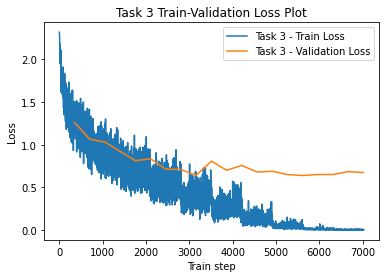

In [276]:
utils.plot_loss(task3_trainer_2.train_history["loss"], "Task 3 - Train Loss")
utils.plot_loss(task3_trainer_2.validation_history["loss"], "Task 3 - Validation Loss")
plt.legend()
plt.ylabel("Loss")
plt.xlabel("Train step")
plt.title("Task 3 Train-Validation Loss Plot")

plt.savefig("task3_loss_plot.png")
plt.show()

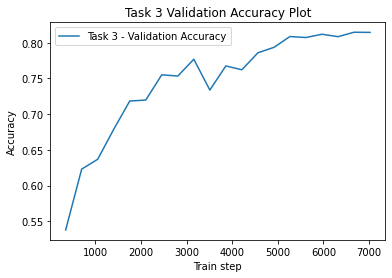

In [277]:
utils.plot_loss(task3_trainer_2.validation_history["accuracy"], "Task 3 - Validation Accuracy")
plt.legend()
plt.ylabel("Accuracy")
plt.xlabel("Train step")
plt.title("Task 3 Validation Accuracy Plot")

plt.savefig("task3_accuracy_plot.png")
plt.show()

Expected Test Accuracy >= 0.8

## Task 3d

Showing the method that improves the accuracy the most, which was to double the number of convolution layers. Accuracy improved from 0.75 to 0.81.

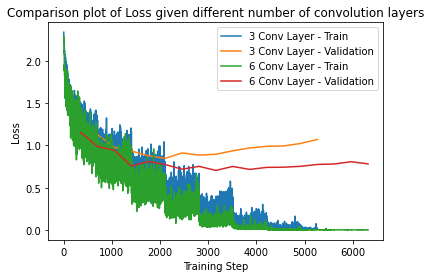

In [315]:
utils.plot_loss(task3_trainer_test.train_history["loss"], "3 Conv Layer - Train")
utils.plot_loss(task3_trainer_test.validation_history["loss"], "3 Conv Layer - Validation")

utils.plot_loss(task3_trainer_1.train_history["loss"], "6 Conv Layer - Train")
utils.plot_loss(task3_trainer_1.validation_history["loss"], "6 Conv Layer - Validation")

plt.legend()
plt.ylabel("Loss")
plt.xlabel("Training Step")
plt.title("Comparison plot of Loss given different number of convolution layers")

plt.savefig("task3d.png")
plt.show()

## Task 3e

Improved Model. Implemented of Model 1 and Model 2 improvements.

In [293]:
class Task3_Model_3(nn.Module):

    def __init__(self,
                 image_channels,
                 num_classes):
        """
            Is called when model is initialized.
            Args:
                image_channels. Number of color channels in image (3)
                num_classes: Number of classes we want to predict (10)
        """
        super().__init__()
        # num_filters = 32  # Set number of filters in first conv layer
        self.num_classes = num_classes

        self.conv_stack = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.BatchNorm2d(128),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.BatchNorm2d(1024)
        )

        self.fc_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(65536, 64),
            nn.ReLU(),
            nn.Linear(64, 10)
        )

    def forward(self, x):
        """
        Performs a forward pass through the model
        Args:
            x: Input image, shape: [batch_size, 3, 32, 32]
        """
        batch_size = x.shape[0]
        out = self.conv_stack(x)
        out = self.fc_stack(out)
        expected_shape = (batch_size, self.num_classes)
        assert out.shape == (batch_size, self.num_classes),\
            f"Expected output of forward pass to be: {expected_shape}, but got: {out.shape}"
        return out

In [294]:
epochs = 10
batch_size = 64
learning_rate = 1e-2 # Should be 5e-5 for LeNet
early_stop_count = 10
dataloaders = load_cifar10(batch_size)
optimizer = torch.optim.SGD
task3_model_3 = Task3_Model_3(image_channels=3, num_classes=10)
task3_trainer_3 = Trainer(
    batch_size,
    learning_rate,
    early_stop_count,
    epochs,
    task3_model_3,
    dataloaders,
    optimizer
)
task3_trainer_3.train()

Files already downloaded and verified
Files already downloaded and verified
Task3_Model_3(
  (conv_stack): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (9): ReLU()
    (10): Conv2d(256, 512, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (11): ReLU()
    (12): Conv2d(512, 1024, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True,

Expected Test Accuracy: >= 0.83

In [82]:
import matplotlib.pyplot as plt

In [ ]:
task3_trainer_3.train_history["loss"]

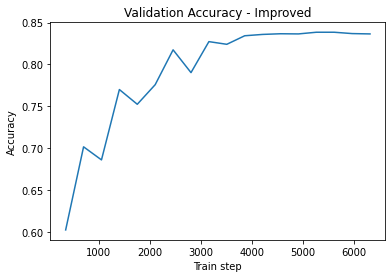

In [280]:
utils.plot_loss(task3_trainer_3.validation_history["accuracy"], "Validation Accuracy - Improved")
plt.title("Validation Accuracy - Improved")
plt.ylabel("Accuracy")
plt.xlabel("Train step")
plt.savefig("task3e.png")
plt.show()

In [119]:
import torchvision

In [281]:
class Task4_Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = torchvision.models.resnet18(pretrained=True)
        self.model.fc = nn.Linear(512, 10) # No need to apply softmax,
        # as this is done in nn.CrossEntropyLoss
        for param in self.model.parameters(): # Freeze all parameters
          param.requires_grad = False
        for param in self.model.fc.parameters(): # Unfreeze the last fully-connected
          param.requires_grad = True # layer
        for param in self.model.layer4.parameters(): # Unfreeze the last 5 convolutional
          param.requires_grad = True # layers
    def forward(self, x):
        x = self.model(x)
        return x

## Create a new function to be put in ```dataloader.py``` called ```load_cifar10_image_net``` to use the optimized mean and std provided by pytorch/ImageNet and to also resize the image to (244, 244).

In [282]:
from torchvision import transforms, datasets
from torch.utils.data.sampler import SubsetRandomSampler
import torch
import typing
import numpy as np
import pathlib
np.random.seed(0)

# mean = (0.5, 0.5, 0.5)
# std = (.25, .25, .25)

# New Mean and Std provided by pytorch/ImageNet
mean_image_net=[0.485, 0.456, 0.406]
std_image_net=[0.229, 0.224, 0.225]

def get_data_dir():
    server_dir = pathlib.Path("/work/datasets/cifar10")
    if server_dir.is_dir():
        return str(server_dir)
    return "data/cifar10"


def load_cifar10_image_net(batch_size: int, validation_fraction: float = 0.1
                 ) -> typing.List[torch.utils.data.DataLoader]:
    # Note that transform train will apply the same transform for
    # validation!
    transform_train = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((224, 224)),
        transforms.Normalize(mean_image_net, std_image_net),
    ])
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((224, 224)),
        transforms.Normalize(mean_image_net, std_image_net)
    ])
    data_train = datasets.CIFAR10(get_data_dir(),
                                  train=True,
                                  download=True,
                                  transform=transform_train)

    data_test = datasets.CIFAR10(get_data_dir(),
                                 train=False,
                                 download=True,
                                 transform=transform_test)

    indices = list(range(len(data_train)))
    split_idx = int(np.floor(validation_fraction * len(data_train)))

    val_indices = np.random.choice(indices, size=split_idx, replace=False)
    train_indices = list(set(indices) - set(val_indices))

    train_sampler = SubsetRandomSampler(train_indices)
    validation_sampler = SubsetRandomSampler(val_indices)

    dataloader_train = torch.utils.data.DataLoader(data_train,
                                                   sampler=train_sampler,
                                                   batch_size=batch_size,
                                                   num_workers=2,
                                                   drop_last=True)

    dataloader_val = torch.utils.data.DataLoader(data_train,
                                                 sampler=validation_sampler,
                                                 batch_size=batch_size,
                                                 num_workers=2)

    dataloader_test = torch.utils.data.DataLoader(data_test,
                                                  batch_size=batch_size,
                                                  shuffle=False,
                                                  num_workers=2)

    return dataloader_train, dataloader_val, dataloader_test


In [283]:
epochs = 5
task4_batch_size = 32
task4_learning_rate = 5e-5 # Should be 5e-5 for LeNet
early_stop_count = 4
dataloaders = load_cifar10_image_net(batch_size)
optimizer = torch.optim.Adam
task4_model = Task4_Model()
task4_trainer = Trainer(
    task4_batch_size,
    task4_learning_rate,
    early_stop_count,
    epochs,
    task4_model,
    dataloaders,
    optimizer
)
task4_trainer.train()

Files already downloaded and verified
Files already downloaded and verified
Task4_Model(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)


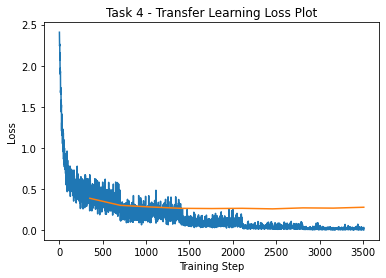

In [284]:
utils.plot_loss(task4_trainer.train_history["loss"], "Task 4 - Train Loss")
utils.plot_loss(task4_trainer.validation_history["loss"], "Task 4 - Validation Loss")

plt.title("Task 4 - Transfer Learning Loss Plot")
plt.ylabel("Loss")
plt.xlabel("Training Step")
plt.savefig("task4a.png")
plt.show()

In [285]:
from PIL import Image

In [286]:
zebra_img = Image.open("images/zebra.jpg") # Open the zebra image in PIL
zebra_tensor = transforms.ToTensor()(zebra_img).unsqueeze_(0)

In [349]:
def torch_image_to_numpy(image: torch.Tensor):
    """
    Function to transform a pytorch tensor to numpy image
    Args:
        image: shape=[3, height, width]
    Returns:
        iamge: shape=[height, width, 3] in the range [0, 1]
    """
    # Normalize to [0 - 1.0]
    image = image.detach().cpu() # Transform image to CPU memory (if on GPU VRAM)
    image = image - image.min()
    image = image / image.max()
    image = image.numpy()
    if len(image.shape) == 2: # Grayscale image, can just return
        return image
    assert image.shape[0] == 3, "Expected color channel to be on first axis. Got: {}".format(image.shape)
    image = np.moveaxis(image, 0, 2)
    return image

In [342]:
indexes_of_interest = [14, 26, 32, 49, 52]

feature_map_activations = torchvision.models.resnet18(pretrained=True).conv1(zebra_tensor)
feature_maps_of_interest = feature_map_activations[0, indexes_of_interest, :, :]

weights_of_interest = torchvision.models.resnet18(pretrained=True).conv1.weight[indexes_of_interest, :, :, :]

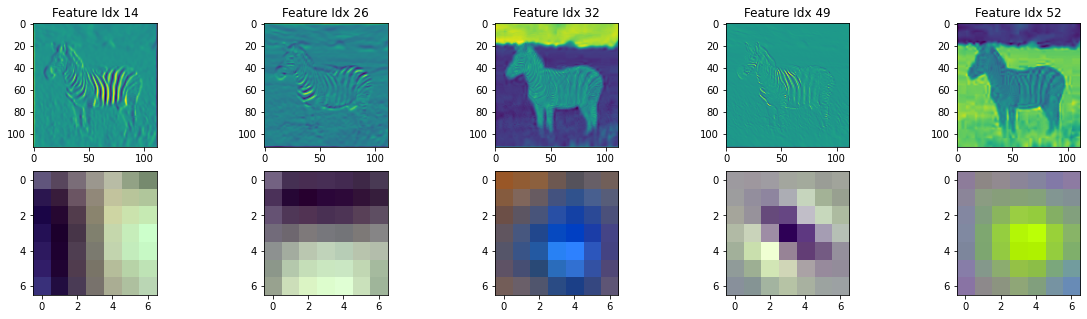

In [348]:
fig, ax = plt.subplots(2, 5, figsize=(20, 5))

for idx, fm in enumerate(feature_maps_of_interest):
  ax[0, idx].set_title(f"Feature Idx {indexes_of_interest[idx]}")
  x = weights_of_interest[idx]
  x = torch_image_to_numpy(x)
  y = fm.detach().numpy()
  ax[0, idx].imshow(y)
  ax[1, idx].imshow(x)

plt.savefig('task4b.png')
plt.show()

In [382]:
count = 0

zebra_cuda = zebra_tensor.cuda()
x = zebra_cuda

stored_layer = None

for block in task4_model.children():
  for idx, child in enumerate(block.children()):
      
    if idx == 8:
      break
    x = child(x)

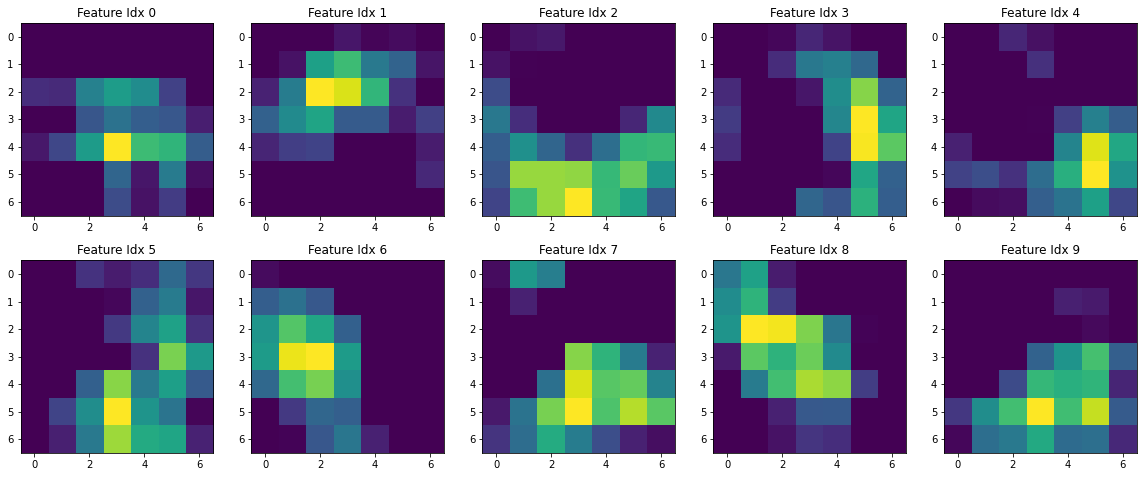

In [391]:
n = 10

idx_of_interest = [i for i in range(n)]
fms = x[0, idx_of_interest, :, :]

fig, ax = plt.subplots(2, n//2, figsize=(20, 8))


for idx, fm in enumerate(fms):
  # ax[idx//5, idx % (n//2)].set_imread("images/zebra.jpg")
  ax[idx//5, idx % (n//2)].set_title(f"Feature Idx {idx_of_interest[idx]}")
  y = fm.cpu().detach().numpy()
  ax[idx//5, idx % (n//2)].imshow(y)

plt.savefig("task4c.png")
plt.show()